Download data

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2023-03-19 21:20:54--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.37, 99.86.38.96, 99.86.38.106, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.5’

data.zip.5          100%[===================>]   2.75M  --.-KB/s    in 0.06s   

2023-03-19 21:20:54 (47.5 MB/s) - ‘data.zip.5’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
data	    sample_data
data.zip    seq2seq_translation_attn_decoder_model_wa_10.pt
data.zip.1  seq2seq_translation_attn_decoder_model_wa_5.pt
data.zip.2  seq2seq_translation_attn_decoder_model_woa_5.pt
data.zip.3  seq2seq_translation_encoder_model_wa_10.pt
data.zip.4  seq2seq_translation_encoder_model_wa_5.pt
data.zip.5  seq2seq_translation_encoder_model_woa_5.pt


In [2]:
%matplotlib inline


Translation with a Sequence to Sequence Network and Attention
*************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

And for more, read the papers that introduced these topics:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__


**Requirements**



In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site http://tatoeba.org/ which has
downloads available at http://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [50]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [51]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [52]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 5 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




### Max length of 5

In [53]:
MAX_LENGTH_5 = 5

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair_5(p):
    return len(p[0].split(' ')) < MAX_LENGTH_5 and \
        len(p[1].split(' ')) < MAX_LENGTH_5 and \
        p[1].startswith(eng_prefixes)


def filterPairs_5(pairs):
    return [pair for pair in pairs if filterPair_5(pair)]

### Max length of 10

In [38]:
MAX_LENGTH_10 = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair_10(p):
    return len(p[0].split(' ')) < MAX_LENGTH_10 and \
        len(p[1].split(' ')) < MAX_LENGTH_10 and \
        p[1].startswith(eng_prefixes)


def filterPairs_10(pairs):
    return [pair for pair in pairs if filterPair_10(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




### Max length of 5

In [54]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs_5 = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs_5))
    pairs_5 = filterPairs_5(pairs_5)
    print("Trimmed to %s sentence pairs" % len(pairs_5))
    print("Counting words...")
    for pair in pairs_5:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs_5


input_lang, output_lang, pairs_5 = prepareData('eng', 'fra', True)
random.shuffle(pairs_5)
train_data_5 = pairs_5[0:int(math.floor(0.8*len(pairs_5)))]
validation_data = pairs_5[int(math.floor(0.8*len(pairs_5)))+1:int(math.floor(0.9*len(pairs_5)))]
test_data_5 = pairs_5[int(math.floor(0.9*len(pairs_5)))+1:]

print(random.choice(pairs_5))

Reading lines...
Read 135842 sentence pairs
Trimmed to 1404 sentence pairs
Counting words...
Counted words:
fra 940
eng 466
['je suis puissant .', 'i m powerful .']


### Max Length of 10

In [39]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs_10 = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs_10))
    pairs_10 = filterPairs_10(pairs_10)
    print("Trimmed to %s sentence pairs" % len(pairs_10))
    print("Counting words...")
    for pair in pairs_10:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs_10


input_lang, output_lang, pairs_10 = prepareData('eng', 'fra', True)
random.shuffle(pairs_10)
train_data_10 = pairs_10[0:int(math.floor(0.8*len(pairs_10)))]
validation_data = pairs_10[int(math.floor(0.8*len(pairs_10)))+1:int(math.floor(0.9*len(pairs_10)))]
test_data_10 = pairs_10[int(math.floor(0.9*len(pairs_10)))+1:]

print(random.choice(pairs_10))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['nous sommes creves .', 'we re pooped .']


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [55]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [56]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





Max length 5
======

In [57]:
class AttnDecoderRNN_5(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH_5):
        super(AttnDecoderRNN_5, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Max Length 10
=====

In [42]:
class AttnDecoderRNN_10(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH_10):
        super(AttnDecoderRNN_10, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [58]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




Attention and Max length 5
========

In [27]:
teacher_forcing_ratio = 0.5


def train_wa_5(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH_5):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Attention and Max length 10
=======

In [44]:
teacher_forcing_ratio = 0.5


def train_wa_10(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH_10):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Without Attention and Max length 5
=======

In [59]:
teacher_forcing_ratio = 0.5


def train_woa_5(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH_5):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Without Attention and Max length 10
======

In [14]:
teacher_forcing_ratio = 0.5


def train_woa_10(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH_10):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden= decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




Attention and Max length 5
=====

In [28]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)  
  
def eval_wa_5(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH_5):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

def eval_dataset_wa_5(dataset, encoder, decoder, criterion):
    loss = 0
    for pair in dataset:
        pair_tensor = tensorsFromPair(pair)
        input_tensor = pair_tensor[0]
        target_tensor = pair_tensor[1]
        loss += eval_wa_5(input_tensor, target_tensor, encoder, decoder, criterion)
    return loss / len(dataset)


Attention and Max length 10
======

In [45]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)  
  
def eval_wa_10(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH_10):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

def eval_dataset_wa_10(dataset, encoder, decoder, criterion):
    loss = 0
    for pair in dataset:
        pair_tensor = tensorsFromPair(pair)
        input_tensor = pair_tensor[0]
        target_tensor = pair_tensor[1]
        loss += eval_wa_10(input_tensor, target_tensor, encoder, decoder, criterion)
    return loss / len(dataset)


Without Attention and Max length 5
======

In [60]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)  
  
def eval_woa_5(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH_5):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

def eval_dataset_woa_5(dataset, encoder, decoder, criterion):
    loss = 0
    for pair in dataset:
        pair_tensor = tensorsFromPair(pair)
        input_tensor = pair_tensor[0]
        target_tensor = pair_tensor[1]
        loss += eval_woa_5(input_tensor, target_tensor, encoder, decoder, criterion)
    return loss / len(dataset)


Without Attention and Max length 10
=======

In [16]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)  
  
def eval_woa_10(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH_10):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

def eval_dataset_woa_10(dataset, encoder, decoder, criterion):
    loss = 0
    for pair in dataset:
        pair_tensor = tensorsFromPair(pair)
        input_tensor = pair_tensor[0]
        target_tensor = pair_tensor[1]
        loss += eval_woa_10(input_tensor, target_tensor, encoder, decoder, criterion)
    return loss / len(dataset)


The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




Attention and Max length 5
======

In [29]:
def trainIters_wa_5(encoder, decoder, n_iters, print_every=2000, plot_every=1000):
    start = time.time()
    all_train_losses_wa_5 = []
    all_validation_losses_wa_5 = []
    train_loss_wa_5 = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    decoder_optimizer = torch.optim.Adam(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(train_data_5))
                      for i in range(n_iters)]
    criterion_wa_5 = nn.NLLLoss()

    print('\nIter \tTrain% \tTime \t\tTrain_loss')
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_wa_5(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion_wa_5)
        train_loss_wa_5 += loss

        if iter % print_every == 0:
            print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_wa_5 / plot_every))

        if iter % plot_every == 0:
            all_train_losses_wa_5.append(train_loss_wa_5 / plot_every)
            train_loss_wa_5 = 0
            
        # Compute loss based on validation data
        if iter % plot_every == 0:
            average_validation_loss_wa_5 = eval_dataset_wa_5(validation_data, encoder, decoder, criterion_wa_5)

            # save model with best validation loss
            if len(all_validation_losses_wa_5) == 0 or average_validation_loss_wa_5 < min(all_validation_losses_wa_5):
                torch.save(encoder, 'seq2seq_translation_encoder_model_wa_5.pt')
                torch.save(decoder, 'seq2seq_translation_attn_decoder_model_wa_5.pt')
            all_validation_losses_wa_5.append(average_validation_loss_wa_5)
    return all_train_losses_wa_5, all_validation_losses_wa_5

#    showPlot_5(all_train_losses_wa_5, all_validation_losses_wa_5)

Attention and Max length 10
=====

In [46]:
def trainIters_wa_10(encoder, decoder, n_iters, print_every=2000, plot_every=1000):
    start = time.time()
    all_train_losses_wa_10 = []
    all_validation_losses_wa_10 = []
    train_loss_wa_10 = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    decoder_optimizer = torch.optim.Adam(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(train_data_10))
                      for i in range(n_iters)]
    criterion_wa_10 = nn.NLLLoss()

    print('\nIter \tTrain% \tTime \t\tTrain_loss')
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_wa_10(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion_wa_10)
        train_loss_wa_10 += loss

        if iter % print_every == 0:
            print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_wa_10 / plot_every))

        if iter % plot_every == 0:
            all_train_losses_wa_10.append(train_loss_wa_10 / plot_every)
            train_loss_wa_10 = 0
            
        # Compute loss based on validation data
        if iter % plot_every == 0:
            average_validation_loss_wa_10 = eval_dataset_wa_10(validation_data, encoder, decoder, criterion_wa_10)

            # save model with best validation loss
            if len(all_validation_losses_wa_10) == 0 or average_validation_loss_wa_10 < min(all_validation_losses_wa_10):
                torch.save(encoder, 'seq2seq_translation_encoder_model_wa_10.pt')
                torch.save(decoder, 'seq2seq_translation_attn_decoder_model_wa_10.pt')
            all_validation_losses_wa_10.append(average_validation_loss_wa_10)
    return all_train_losses_wa_10, all_validation_losses_wa_10

#    showPlot_10(all_train_losses_wa_10, all_validation_losses_wa_10)

Without Attention and Max length 5
=====

In [61]:
def trainIters_woa_5(encoder, decoder, n_iters, print_every=2000, plot_every=1000):
    start = time.time()
    all_train_losses_woa_5 = []
    all_validation_losses_woa_5 = []
    train_loss_woa_5 = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    decoder_optimizer = torch.optim.Adam(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(train_data_5))
                      for i in range(n_iters)]
    criterion_woa_5 = nn.NLLLoss()

    print('\nIter \tTrain% \tTime \t\tTrain_loss')
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_woa_5(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion_woa_5)
        train_loss_woa_5 += loss

        if iter % print_every == 0:
            print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_woa_5 / plot_every))

        if iter % plot_every == 0:
            all_train_losses_woa_5.append(train_loss_woa_5 / plot_every)
            train_loss_woa_5 = 0
            
        # Compute loss based on validation data
        if iter % plot_every == 0:
            average_validation_loss_woa_5 = eval_dataset_woa_5(validation_data, encoder, decoder, criterion_woa_5)

            # save model with best validation loss
            if len(all_validation_losses_woa_5) == 0 or average_validation_loss_woa_5 < min(all_validation_losses_woa_5):
                torch.save(encoder, 'seq2seq_translation_encoder_model_woa_5.pt')
                torch.save(decoder, 'seq2seq_translation_attn_decoder_model_woa_5.pt')
            all_validation_losses_woa_5.append(average_validation_loss_woa_5)
    return all_train_losses_woa_5, all_validation_losses_woa_5

#    showPlot_5(all_train_losses_wa_5, all_validation_losses_wa_5)

Without Attention and Max length 10
=====

In [17]:
def trainIters_woa_10(encoder, decoder, n_iters, print_every=2000, plot_every=1000):
    start = time.time()
    all_train_losses_woa_10 = []
    all_validation_losses_woa_10 = []
    train_loss_woa_10 = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    decoder_optimizer = torch.optim.Adam(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(train_data_10))
                      for i in range(n_iters)]
    criterion_woa_10 = nn.NLLLoss()

    print('\nIter \tTrain% \tTime \t\tTrain_loss')
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_woa_10(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion_woa_10)
        train_loss_woa_10 += loss

        if iter % print_every == 0:
            print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_woa_10 / plot_every))

        if iter % plot_every == 0:
            all_train_losses_woa_10.append(train_loss_woa_10 / plot_every)
            train_loss_woa_10 = 0
            
        # Compute loss based on validation data
        if iter % plot_every == 0:
            average_validation_loss_woa_10 = eval_dataset_woa_10(validation_data, encoder, decoder, criterion_woa_10)

            # save model with best validation loss
            if len(all_validation_losses_woa_10) == 0 or average_validation_loss_woa_10 < min(all_validation_losses_woa_10):
                torch.save(encoder, 'seq2seq_translation_encoder_model_woa_10.pt')
                torch.save(decoder, 'seq2seq_translation_attn_decoder_model_woa_10.pt')
            all_validation_losses_woa_10.append(average_validation_loss_woa_10)
    return all_train_losses_woa_10, all_validation_losses_woa_10

#    showPlot_10(all_train_losses_wa_10, all_validation_losses_wa_10)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




Attention and Max length 5
======

In [30]:
def evaluate_wa_5(encoder, decoder, sentence, max_length=MAX_LENGTH_5):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

Attention and Max length 10
======

In [47]:
def evaluate_wa_10(encoder, decoder, sentence, max_length=MAX_LENGTH_10):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

Without Attention and Max length 5
======

In [62]:
def evaluate_woa_5(encoder, decoder, sentence, max_length=MAX_LENGTH_5):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

Without Attention and Max length 10
======

In [18]:
def evaluate_woa_10(encoder, decoder, sentence, max_length=MAX_LENGTH_10):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




Attention and Max length 5
======

In [31]:
def evaluateRandomly_wa_5(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs_5)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate_wa_5(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Attention and Max length 10
=======

In [48]:
def evaluateRandomly_wa_10(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs_10)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate_wa_10(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Without Attention and Max length 5
=====

In [63]:
def evaluateRandomly_woa_5(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs_5)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate_woa_5(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Without Attention and Max length 10
======

In [19]:
def evaluateRandomly_woa_10(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs_10)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate_woa_10(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 32 hidden nodes and a
single GRU layer. 

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




Attention and Max length 5
=====

In [32]:
hidden_size = 32
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder_wa_5 = AttnDecoderRNN_5(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

all_train_losses_wa_5, all_validation_losses_wa_5 = trainIters_wa_5(encoder, attn_decoder_wa_5, 30000)

# evaluate on test set and print average test loss
encoder = torch.load('seq2seq_translation_encoder_model_wa_5.pt')
attn_decoder_wa_5 = torch.load('seq2seq_translation_attn_decoder_model_wa_5.pt')
average_test_loss = eval_dataset_wa_5(test_data_5, encoder, attn_decoder_wa_5, nn.NLLLoss())
print('Average test loss: ' + str(average_test_loss))


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 30s) 	1.4369
4000 	13% 	(0m 58s) 	1.2221
6000 	20% 	(1m 28s) 	1.1272
8000 	26% 	(1m 56s) 	1.0818
10000 	33% 	(2m 25s) 	1.0249
12000 	40% 	(2m 54s) 	0.9549
14000 	46% 	(3m 23s) 	0.9089
16000 	53% 	(3m 52s) 	0.8636
18000 	60% 	(4m 21s) 	0.8140
20000 	66% 	(4m 50s) 	0.7678
22000 	73% 	(5m 20s) 	0.7250
24000 	80% 	(5m 48s) 	0.6642
26000 	86% 	(6m 16s) 	0.6143
28000 	93% 	(6m 44s) 	0.5716
30000 	100% 	(7m 14s) 	0.5321
Average test loss: 1.4257641148567195


Attention and Max length 10
=====

In [49]:
hidden_size = 32
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder_wa_10 = AttnDecoderRNN_10(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

all_train_losses_wa_10, all_validation_losses_wa_10 = trainIters_wa_10(encoder, attn_decoder_wa_10, 30000)

# evaluate on test set and print average test loss
encoder = torch.load('seq2seq_translation_encoder_model_wa_10.pt')
attn_decoder_wa_10 = torch.load('seq2seq_translation_attn_decoder_model_wa_10.pt')
average_test_loss = eval_dataset_wa_10(test_data_10, encoder, attn_decoder_wa_10, nn.NLLLoss())
print('Average test loss: ' + str(average_test_loss))


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 43s) 	3.2164
4000 	13% 	(1m 34s) 	2.8738
6000 	20% 	(2m 24s) 	2.7738
8000 	26% 	(3m 11s) 	2.6954
10000 	33% 	(3m 59s) 	2.6100
12000 	40% 	(4m 46s) 	2.5560
14000 	46% 	(5m 34s) 	2.4933
16000 	53% 	(6m 21s) 	2.4148
18000 	60% 	(7m 8s) 	2.4226
20000 	66% 	(7m 55s) 	2.3903
22000 	73% 	(8m 43s) 	2.3156
24000 	80% 	(9m 30s) 	2.2836
26000 	86% 	(10m 17s) 	2.3049
28000 	93% 	(11m 5s) 	2.2811
30000 	100% 	(11m 52s) 	2.2517
Average test loss: 2.6909110791956494


Without Attention and Max length 5
======

In [64]:
hidden_size = 32
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
#attn_decoder_woa_5 = AttnDecoderRNN_5(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
decoder= DecoderRNN(hidden_size, output_lang.n_words).to(device)
all_train_losses_woa_5, all_validation_losses_woa_5 = trainIters_woa_5(encoder, decoder, 30000)

# evaluate on test set and print average test loss
encoder = torch.load('seq2seq_translation_encoder_model_woa_5.pt')
attn_decoder_woa_5 = torch.load('seq2seq_translation_attn_decoder_model_woa_5.pt')
average_test_loss = eval_dataset_woa_5(test_data_5, encoder, attn_decoder_woa_5, nn.NLLLoss())
print('Average test loss: ' + str(average_test_loss))


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 19s) 	1.4358
4000 	13% 	(0m 37s) 	1.2317
6000 	20% 	(0m 55s) 	1.1362
8000 	26% 	(1m 13s) 	1.0814
10000 	33% 	(1m 31s) 	1.0197
12000 	40% 	(1m 49s) 	0.9617
14000 	46% 	(2m 7s) 	0.9008
16000 	53% 	(2m 24s) 	0.8561
18000 	60% 	(2m 43s) 	0.8163
20000 	66% 	(3m 0s) 	0.7793
22000 	73% 	(3m 18s) 	0.7212
24000 	80% 	(3m 36s) 	0.6689
26000 	86% 	(3m 54s) 	0.6519
28000 	93% 	(4m 12s) 	0.6064
30000 	100% 	(4m 30s) 	0.5850
Average test loss: 1.4026227838652472


Without Attention and Max length 10
======

In [20]:
hidden_size = 32
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
#attn_decoder_woa_10 = AttnDecoderRNN_10(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
all_train_losses_woa_10, all_validation_losses_woa_10 = trainIters_woa_10(encoder, decoder, 30000)

# evaluate on test set and print average test loss
encoder = torch.load('seq2seq_translation_encoder_model_woa_10.pt')
attn_decoder_woa_10 = torch.load('seq2seq_translation_attn_decoder_model_woa_10.pt')
average_test_loss = eval_dataset_woa_10(test_data_10, encoder, attn_decoder_woa_10, nn.NLLLoss())
print('Average test loss: ' + str(average_test_loss))


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 30s) 	3.2142
4000 	13% 	(1m 3s) 	2.9077
6000 	20% 	(1m 37s) 	2.7942
8000 	26% 	(2m 13s) 	2.7675
10000 	33% 	(2m 47s) 	2.6792
12000 	40% 	(3m 22s) 	2.6057
14000 	46% 	(3m 54s) 	2.5780
16000 	53% 	(4m 28s) 	2.4814
18000 	60% 	(5m 3s) 	2.4611
20000 	66% 	(5m 38s) 	2.3960
22000 	73% 	(6m 13s) 	2.3939
24000 	80% 	(6m 47s) 	2.3295
26000 	86% 	(7m 25s) 	2.2920
28000 	93% 	(7m 58s) 	2.3368
30000 	100% 	(8m 33s) 	2.3016
Average test loss: 2.8052439994242073


<Figure size 432x288 with 0 Axes>

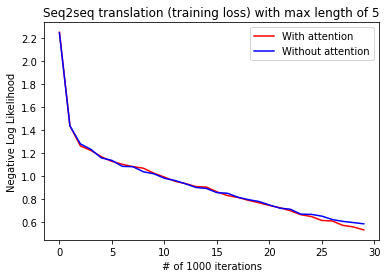

<Figure size 432x288 with 0 Axes>

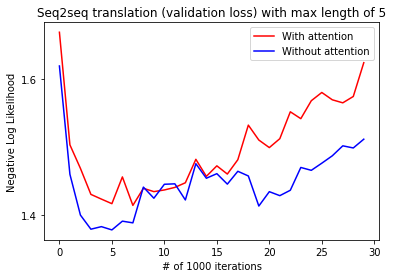

<Figure size 432x288 with 0 Axes>

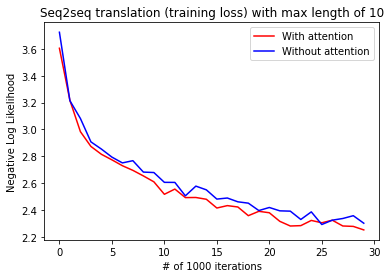

<Figure size 432x288 with 0 Axes>

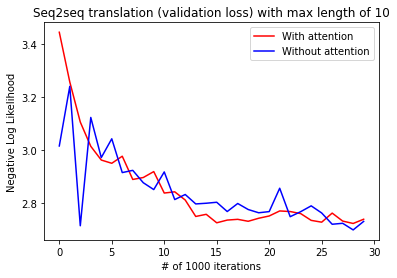

In [65]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


#def showPlot_5(all_train_losses, all_validation_losses):
plt.figure()
fig, ax = plt.subplots()
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(all_train_losses_wa_5, color = "red", label = "With attention")
plt.plot(all_train_losses_woa_5  , color = "blue", label = "Without attention")

plt.title('Seq2seq translation (training loss) with max length of 5')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend( loc='upper right')

plt.figure()
fig, ax = plt.subplots()
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(all_validation_losses_wa_5, color = "red", label = "With attention")
plt.plot(all_validation_losses_woa_5, color = "blue", label = "Without attention")

plt.title('Seq2seq translation (validation loss) with max length of 5')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend( loc='upper right')


plt.figure()
fig, ax = plt.subplots()
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(all_train_losses_wa_10, color = "red", label = "With attention")
plt.plot(all_train_losses_woa_10, color = "blue", label = "Without attention")
plt.title('Seq2seq translation (training loss) with max length of 10')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend( loc='upper right')

plt.figure()
fig, ax = plt.subplots()
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(all_validation_losses_wa_10, color = "red", label = "With attention")
plt.plot(all_validation_losses_woa_10, color = "blue", label = "Without attention")
plt.title('Seq2seq translation (validation loss) with max length of 10')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(loc='upper right')

Explanation
=====
For shorter input sequences (e.g., length of 5), the non-attention RNN seq2seq model may perform well enough without the need for an additional attention mechanism.
For longer input sequences, the non-attention RNN seq2seq model may struggle to capture all the relevant information in the fixed-length context vector.
Transformers, they are particularly suited for handling long sequences, which allows them to attend to all input tokens at each layer

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there


